# Neural Lyapunov for a damped harmonic oscillator

In this notebook we attempt to discover a neural Lyapunov function for the damped harmonic oscillator system, which has dynamics given by
$$ \ddot{x} + 2 \zeta \omega_0 \dot{x} + \omega_0^2 x = 0, $$
where the natural frequency is $\omega_0 > 0$ and the damping constant is $\zeta > 0$.

Consider $V(x, \dot{x}) = \frac{1}{2} \dot{x}^2 + \frac{1}{2} \omega_0^2 x^2$.
Then, $V > 0 \forall x, \dot{x},$ except the fixed point at the origin, $V(0,0) = 0$, and 
$$  \begin{align*}
        \dot{V} &= \dot{x} \ddot{x} + \omega_0^2 x \dot{x}, \\
                &= \dot{x} \left( -2 \zeta \omega_0 \dot{x} - \omega_0^2 x + \omega_0^2 x \right) \\
                &= -2 \zeta \omega_0 \dot{x}^2,
    \end{align*}
$$
is nonpositive for all $(x, \dot{x})$, thus satisfying the Lyapunov condition and showing that $(x, \dot{x}) = 0$ is a stable equilibrium in the sense of Lyapunov (i.s.L.).
Additionally, since $\sqrt{x^2 + \dot{x}^2} \to \infty \implies V(x, \dot{x}) \to \infty$, LaSalle's theorem guarantees asymptotic convergence to the largest invariant set with $\dot{V} = 0$, which is just the fixed point at the origin.

We hope to find a neural network that can similarly show this equilibrium to be stable.
Note that the system is actually globally, exponentially stable, which is stronger than asymptotically stable, which is stronger than stable i.s.L.
Ability to prove these stronger versions of stability is also desirable.

# Simulation

First, let's try to just simulate a pendulum.

In [1]:
using ModelingToolkit

In [2]:
# Set up the ODE
@variables t x(t)
@parameters ζ ω_0
Dt = Differential(t)
DDt = Dt^2

@named damped_sho = ODESystem(DDt(x) ~ -2ζ*ω_0*Dt(x) - ω_0^2*x , t )

Model damped_sho with 1 equations
States (1):
  x(t)
Parameters (2):
  ζ
  ω_0

In [23]:
damped_sho_simplified = structural_simplify(damped_sho)

Model damped_sho with 2 equations
States (2):
  xˍt(t)
  x(t)
Parameters (2):
  ζ
  ω_0
Incidence matrix:sparse([1, 2, 1, 2, 1], [1, 2, 3, 3, 4], Num[×, ×, ×, ×, ×], 2, 4)

In [22]:
using DifferentialEquations

In [32]:
prob = ODEProblem(damped_sho_simplified, [x => 1, Dt(x) => -10.0], (0.0, 25.0), [ζ => 0.1, ω_0 => 2])

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 25.0)
u0: 2-element Vector{Float64}:
 -10.0
   1.0

In [33]:
using Plots

In [34]:
sol = solve(prob);

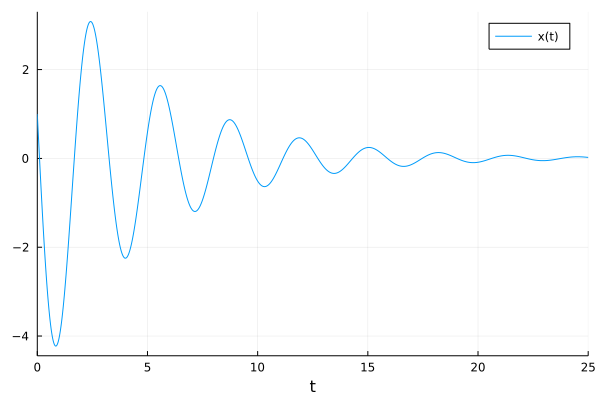

In [35]:
plot(sol,vars=x)

# Lyapunov conditions for stability i.s.L.

For a system with dynamics $\dot{\mathbf{x}} = f(\mathbf{x})$ with a fixed point at the origin, a Lyapunov function $V(\mathbf{x})$ proves stability i.s.L. if, in some open set surrounding the origin,
$$ \begin{gather*}
    V(\mathbf{x}) \succ 0, \\
    \dot{V}(\mathbf{x}) \preceq 0.
\end{gather*}$$

There are modifications to this that can be made to ensure global, asymptotic, and/or exponential stability, but we begin with the weakest form of stability, which simplifies the set up in some ways.

# Neural Lyapunov set-up

Let the domain we consider be the box $-10 < x, \dot{x}, < 10$, which we will denote $\mathcal{D}$.
Following _Lyapunov-Net_ by Gaby et. al. 2021, we can satisfy $V(\mathbf{x}) \succ 0$ by letting,
$$ V(\mathbf{x}) = \left\lVert \phi_\theta(\mathbf{x}) - \phi_\theta(\mathbf{0}) \right\rVert^2 + \delta \log(1 + \left\lVert \mathbf{x} \right\rVert^2) , $$
where $\mathbf{x} = (x, \dot{x})$ and $\delta > 0$ is a hyperparameter.
Then, $\dot{V} \preceq 0$ is a partial differential inequality given by
$$ (\nabla V) \cdot f(\mathbf{x}) \le 0.$$
(Note that $\dot{V}(\mathbf{0}) = 0$ is guaranteed by $f(\mathbf{0}) = \mathbf{0}$, which is required for the origin to be a fixed point.)
Plugging in our formula for $V$ yields
$$ \left((\nabla_\mathbf{x} \phi_\theta) (\phi_\theta(\mathbf{x}) - \phi_\theta(\mathbf{0})) + \frac{(2 \delta) \mathbf{x}}{1 + \left\lVert \mathbf{x} \right\rVert^2} \right) \cdot f(\mathbf{x}) \le 0. $$
This partial differential inequality can be made into a partial differential equation using the ReLU function (though this messes with differentiability):
$$ ReLU \left(\left((\nabla_\mathbf{x} \phi_\theta) (\phi_\theta(\mathbf{x}) - \phi_\theta(\mathbf{0})) + \frac{(2 \delta) \mathbf{x}}{1 + \left\lVert \mathbf{x} \right\rVert^2} \right) \cdot f(\mathbf{x}) \right) = 0. $$
Thus, a suitable loss function is
$$ \ell(\theta) = \int_{\mathbf{x} \in \mathcal{D}} ReLu \left( \left((\nabla_\mathbf{x} \phi_\theta) (\phi_\theta(\mathbf{x}) - \phi_\theta(\mathbf{0})) + \frac{(2 \delta) \mathbf{x}}{1 + \left\lVert \mathbf{x} \right\rVert^2} \right) \cdot f(\mathbf{x}) \right) d\mathbf{x}, $$
Which should achieve a minimal value of zero if and only if $\dot{V} \le 0$ for all $\mathbf{x} \in \mathcal{D}$.
(If $\phi_\theta$ isn't constrained to be continuous, then technically $\dot{V}$ could be positive on a set of measure zero, but continuity of $\phi_\theta$ implies that $\dot{V}$ cannot be positive only on a set of measure zero.)

In [73]:
using ModelingToolkit, LinearAlgebra

In [74]:
@parameters x v
@variables φ(..)
Dx = Differential(x)
Dv = Differential(v)

# Constants     TODO: Can these be made into parameters?
δ = 1e-3
ζ = 0.1
ω_0 = 2.

# Equations
f(x,v) = [  v ;
            -2ζ*ω_0*v - ω_0^2*x]
V(x,v) = norm(φ(x,v) - φ(0.,0.))^2 + δ * log(1.0 + x^2 + v^2) # TODO change abs to norm
DV(x,v) =   f(x,v) ⋅ (transpose([Dx(φ(x,v)) Dv(φ(x,v))]) * 
            (φ(x,v) - φ(0,0)) + 2δ/(1 + x^2 + v^2) * [x; v])
#DV(x,v) = f(x,v) ⋅ [Dx(V(x,v)); Dv(V(x,v))] # Is it better to define like this or the line above?
eq = max(0, DV(x,v)) ~ 0
#eq = log(1.0 + exp(10.0*DV(x,v))) ~ 0. # Differentiable, approximate ReLU
# TODO: Try maybe defining eq without using f or V? (even though I think that should work)

# Boundary conditions (TODO: The solver accepts this bc, but is there a better option?)
bcs = [0.0 ~ 0.0]

# Domain
domains = [ x ∈ (-10.,10.),
            v ∈ (-10.,10.) ]

# Combine into a PDESystem
@named lyapunov_pde =   PDESystem(eq, bcs, domains, [x,v], [φ(x,v)])#, [δ, ζ, ω_0])
#values: , [δ => 1e-3, ζ => 0.1, ω_0 => 2]

PDESystem
Equations: Equation[max(0, (-0.4v - 4.0x)*((φ(x, v) - φ(0, 0))*Differential(v)(φ(x, v)) + (0.002v) / (1 + v^2 + x^2)) + v*((φ(x, v) - φ(0, 0))*Differential(x)(φ(x, v)) + (0.002x) / (1 + v^2 + x^2))) ~ 0]
Boundary Conditions: Equation[0.0 ~ 0.0]
Domain: Symbolics.VarDomainPairing[Symbolics.VarDomainPairing(x, -10.0..10.0), Symbolics.VarDomainPairing(v, -10.0..10.0)]
Dependent Variables: Num[φ(x, v)]
Independent Variables: Num[x, v]
Parameters: SciMLBase.NullParameters()
Default Parameter ValuesDict{Any, Any}()

In [75]:
using Flux, DiffEqFlux

In [76]:
in_dim = 2      # x and v
out_dim = 1     # φ (hopefully we can increase this dimension later)
hidden_dim = 16

chain = FastChain(
    FastDense(in_dim, hidden_dim, Flux.tanh), 
    FastDense(hidden_dim, hidden_dim, Flux.tanh), 
    FastDense(hidden_dim, out_dim)
    )

# Initial parameters of NeuralNetwork
init0 = Float64.(DiffEqFlux.initial_params(chain));

In [77]:
using NeuralPDE

In [78]:
dx = 0.1
strategy = GridTraining(dx)
discretization = PhysicsInformedNN(chain, strategy, init_params = init0)

prob = discretize(lyapunov_pde, discretization)

OptimizationProblem. In-place: true
u0: 337-element Vector{Float64}:
 -0.33363258838653564
  0.3761036992073059
 -0.16413350403308868
  0.3845422565937042
  0.29197022318840027
 -0.05582182854413986
 -0.4239655137062073
  0.23505379259586334
 -0.10050493478775024
 -0.06265351921319962
  ⋮
  0.11859826743602753
  0.5170382261276245
  0.08970200270414352
  0.39185968041419983
  0.4143562912940979
 -0.4407828152179718
  0.5566853880882263
  0.057891108095645905
  0.0

In [79]:
using Optim, GalacticOptim

In [80]:
opt = Optim.BFGS()

# A callback to print the loss
cb = function (p,l)
    println("Current loss is: $l")
    return false
end

#63 (generic function with 1 method)

In [81]:
res = GalacticOptim.solve(prob, opt, cb=cb, maxiters=1000)
phi = discretization.phi

Current loss is: 0.0


#298 (generic function with 1 method)

In [82]:
φ_fun(x,v) = first(phi([x,v],res.minimizer));
V_fun(x,v) = norm(φ_fun(x,v) - φ_fun(0.,0.))^2 + δ * log(1.0 + x^2 + v^2) 

V_fun (generic function with 1 method)

In [83]:
xs,vs = [ModelingToolkit.infimum(d.domain):dx/2:ModelingToolkit.supremum(d.domain) for d in domains]

V_predict = reshape([V_fun(x,v) for x in xs for v in vs], (length(xs), length(vs)));

In [84]:
using Plots

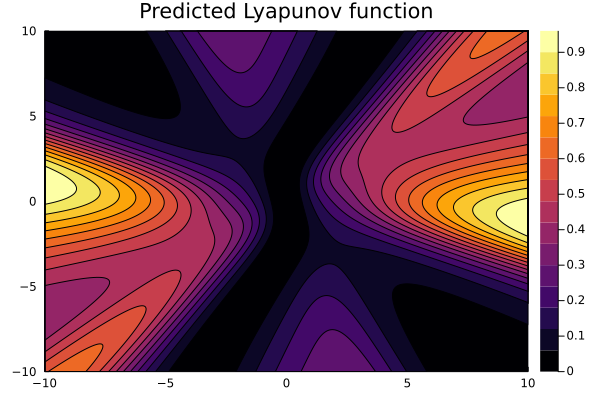

In [85]:
plot(xs, vs, V_predict, linetype=:contourf,title = "Predicted Lyapunov function")